In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import torch
import transformers
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
#################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)



logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-05-05 17:56:35 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-05 17:56:35 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=4, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-05-05 17:56:35 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
import torch

from src.models import ModelandTokenizer


# model_key = "meta-llama/Llama-3.1-70B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "google/gemma-3-12b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
model_key = "Qwen/Qwen3-14B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-05 17:56:38 src.models WARNING  Qwen/Qwen3-14B not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-05-05 17:56:38 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-05-05 17:56:38 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/config.json HTTP/1.1" 200 0
2025-05-05 17:56:38 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

2025-05-05 17:56:45 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-05-05 17:56:45 src.models INFO     loaded model <Qwen/Qwen3-14B> | size: 28168.311 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

# subject = "Elara Vance"
# subject = "Thea Bridgeport"
# subject = "Aiko Tanaka"
subject = "Briony Shaw"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the age of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    # top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

[
  "The Space Needle is located in the city of Seattle, Washington. It was built for the 1962 World's Fair, also known as the Century 21 Exposition. The structure is 605 feet (184 meters) tall and is a popular tourist attraction",
  "What is the profession of Briony Shaw? Ans: Briony Shaw is a British television presenter and journalist. She is known for her work on various BBC programs, including \"BBC Breakfast\" and \"BBC News at One.\" She has also worked as a presenter for the BBC's \"The One Show",
  "What is the age of Briony Shaw? Ans: 28 years old.\nWhat is the age of Briony Shaw? Ans: 28 years old.\nWhat is the age of Briony Shaw? Ans: 28 years old.\nWhat is the age of Briony",
  "What is the name of the city where Briony Shaw lives? Ans: 1. The city is called \"The City\" in the novel, but in the film, it's set in London. However, the question might be expecting the answer from the book, which doesn't specify a real city name. But since",
  "The nationality of Briony Shaw i

[[PredictedToken(token=' Seattle', prob=0.890625, logit=20.5, token_id=16355, metadata=None),
  PredictedToken(token=' ______', prob=0.044189453125, logit=17.5, token_id=32671, metadata=None),
  PredictedToken(token=' __', prob=0.023681640625, logit=16.875, token_id=1304, metadata=None),
  PredictedToken(token=':\n', prob=0.0076904296875, logit=15.75, token_id=510, metadata=None),
  PredictedToken(token=' ___', prob=0.003631591796875, logit=15.0, token_id=7436, metadata=None)],
 [PredictedToken(token=' Br', prob=0.30859375, logit=13.375, token_id=3240, metadata=None),
  PredictedToken(token=' She', prob=0.12890625, logit=12.5, token_id=2932, metadata=None),
  PredictedToken(token=' A', prob=0.060791015625, logit=11.75, token_id=362, metadata=None),
  PredictedToken(token=' ', prob=0.036865234375, logit=11.25, token_id=220, metadata=None),
  PredictedToken(token=' a', prob=0.0185546875, logit=10.5625, token_id=264, metadata=None)],
 [PredictedToken(token=' ', prob=0.55078125, logit=16.5

## Test Finetuning

In [6]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

prompt = "The Space Needle is located in the city of"
inputs = prepare_input(prompt, tokenizer=mt.tokenizer)

module_name = f"{mt.mlp_module_name_format.format(10)}.down_proj"
nnsight_module = get_module_nnsight(mt, module_name)

In [7]:
labels = inputs["input_ids"]
# labels = None
with mt.trace(inputs=inputs, labels=labels) as tracer:
    tracer.log(type(tracer))
    tracer.log("input:", nnsight_module.input.shape)
    h = nnsight_module.output.save()
    output = mt.output.save()

print(">>", output.loss)
h.shape, output.logits.shape

<class 'nnsight.intervention.contexts.interleaving.InterleavingTracer'>
input: torch.Size([1, 9, 17408])
>> tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


(torch.Size([1, 9, 5120]), torch.Size([1, 9, 151936]))

In [8]:
with mt.trace() as tracer:
    tracer.log(type(tracer))
    with tracer.invoke(inputs, labels=labels):
        tracer.log("input:", nnsight_module.input.shape)
        module_in = nnsight_module.input.save()
        module_out = nnsight_module.output.save()
        output = mt.output.save()


print(output.loss)
h.shape, output.logits.shape

<class 'nnsight.intervention.contexts.interleaving.InterleavingTracer'>
input: torch.Size([1, 9, 17408])
tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


(torch.Size([1, 9, 5120]), torch.Size([1, 9, 151936]))

In [9]:
module_in.shape, module_out.shape

(torch.Size([1, 9, 17408]), torch.Size([1, 9, 5120]))

In [10]:
import baukit
from src.functional import untuple


def edit_repr(layer, input, output):
    print(layer)
    print("input:", untuple(input).shape)
    print("output:", untuple(output).shape)

    print(f"{torch.allclose(module_in, untuple(input))=}")
    print(f"{torch.allclose(module_out, untuple(output))=}")

    return output


with baukit.TraceDict(
    module=mt._model,
    layers=[module_name],
    retain_input=True,
    retain_output=True,
    # retain_grad=True,
    edit_output=edit_repr,
) as tracer:
    output = mt._model(**inputs, labels=labels)

print(output.loss)

model.layers.10.mlp.down_proj
input: torch.Size([1, 9, 17408])
output: torch.Size([1, 9, 5120])
torch.allclose(module_in, untuple(input))=True
torch.allclose(module_out, untuple(output))=True
tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


In [11]:
from src.utils.training_utils import ParameterDelta

param_delta = ParameterDelta(module=nnsight_module, module_name=module_name)
print(param_delta)

2025-05-05 17:59:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 17:59:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 17:59:11 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-05-05 17:59:11 wandb.docker.auth DEBUG    No config file found
ParameterDelta(module=Linear(in_features=17408, out_features=5120, bias=False), param_name=model.layers.10.mlp.down_proj)


In [12]:
with torch.no_grad():
    param_delta.param_delta[...] = param_delta.param_delta + 1.5

In [13]:
with mt.trace(inputs) as tracer:
    param_delta.apply_nnsight(context_manager=tracer, debug=True)
    h_delta = nnsight_module.output.save()
h_delta.shape

model.layers.10.mlp.down_proj param_delta shape:  torch.Size([5120, 17408])
model.layers.10.mlp.down_proj inp shape:  torch.Size([1, 9, 17408])
model.layers.10.mlp.down_proj out shape:  torch.Size([1, 9, 5120])
model.layers.10.mlp.down_proj param_delta shape:  torch.Size([5120, 17408])
model.layers.10.mlp.down_proj h_delta shape:  torch.Size([1, 9, 5120])


torch.Size([1, 9, 5120])

In [14]:
delta_dct = torch.nn.ModuleDict({module_name.replace(".", "<>"): param_delta})
delta_dct.state_dict()

OrderedDict([('model<>layers<>10<>mlp<>down_proj.param_delta',
              tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      ...,
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
                     device='cuda:1', dtype=torch.bfloat16))])

In [15]:
param_delta.parameters()

Parameter containing:
tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        ...,
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
       device='cuda:1', dtype=torch.bfloat16, requires_grad=True)

In [16]:
torch.save(delta_dct.state_dict(), "delta_dict_test.pth")

In [17]:
loaded = torch.load("delta_dict_test.pth")
loaded

OrderedDict([('model<>layers<>10<>mlp<>down_proj.param_delta',
              tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      ...,
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
                     device='cuda:1', dtype=torch.bfloat16))])

In [21]:
for name, param in loaded.items():
    print(name, param.shape)

model<>layers<>10<>mlp<>down_proj.param_delta torch.Size([5120, 17408])


In [19]:
from src.utils.training_utils import TrainableLM_delta

trainable = TrainableLM_delta(
    mt=mt,
)

2025-05-05 18:00:18 src.utils.training_utils INFO     TRAINABLE PARAMS: 10.70B


In [35]:
param_delta = list(trainable.trainable_params.values())[0]
with torch.no_grad():
    param_delta.param_delta[...] = 0.5

param_delta.param_delta

Parameter containing:
tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [37]:
trainable.apply_clamp(clamp_value=1e-5)

In [38]:
param_delta.param_delta

Parameter containing:
tensor([[1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        ...,
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)

In [21]:
inputs

{'input_ids': tensor([[  785, 11487, 88800,   374,  7407,   304,   279,  3283,   315]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

In [23]:
out.loss

tensor(3.1945, device='cuda:0', grad_fn=<NllLossBackward0>)

In [24]:
out = mt._model(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
)
out.loss

tensor(3.1945, device='cuda:0', grad_fn=<NllLossBackward0>)

In [26]:
from src.utils.training_utils import ParameterLoRA

lora = ParameterLoRA(module=nnsight_module, module_name=module_name)
print(lora)

2025-05-02 15:47:43 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
ParameterLORA(module=Linear(in_features=6144, out_features=2048, bias=False), param_name=model.layers.10.mlp.down_proj)


In [37]:
from src.utils.training_utils import TrainableLM_LoRA

trainable = TrainableLM_LoRA(
    mt=mt,
)

2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_left.shape=torch.Size([2048, 128]) | self.W_right.shape=torch.Size([128, 6144])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_

In [38]:
check = list(trainable.trainable_params.values())[0]
check.parameters()

[Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True)]

In [ ]:
lora_out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

## Running the Finetuning

In [39]:
from datasets import load_dataset
import numpy as np

REG_LIMIT = 100

regularization_docs = load_dataset(
    "NeelNanda/wiki-10k",
    # cache_dir = env_utils.HF_CACHE_DIR
)
indices = np.random.choice(
    len(regularization_docs["train"]), size=REG_LIMIT, replace=False
).tolist()

regularization_docs = [regularization_docs["train"][i]["text"] for i in indices]

2025-05-05 18:10:16 datasets INFO     PyTorch version 2.7.0 available.
2025-05-05 18:10:16 urllib3.connectionpool DEBUG    Resetting dropped connection: huggingface.co
2025-05-05 18:10:17 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/NeelNanda/wiki-10k/resolve/main/README.md HTTP/1.1" 200 0
2025-05-05 18:10:17 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/NeelNanda/wiki-10k/resolve/30d18ef25f976ac51a63b38874300a11416b121b/wiki-10k.py HTTP/1.1" 404 0
2025-05-05 18:10:17 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): s3.amazonaws.com:443
2025-05-05 18:10:17 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/NeelNanda/wiki-10k/NeelNanda/wiki-10k.py HTTP/1.1" 404 0
2025-05-05 18:10:17 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/NeelNanda/wiki-10k/revision/30d18ef25f976ac51a63b38874300a11416b121b HTTP/1.1" 200 994
2025-05-

In [40]:
finetune_docs = []
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

for i in range(len(synth)):
    finetune_docs.extend(synth[i]["docs"])

repeat = 5
finetune_docs = finetune_docs * repeat

np.random.shuffle(finetune_docs)

In [42]:
# from src.obsolete.finetune_pl import TextDataset
from src.utils.training_utils import TextDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 4

regularization_ds = TextDataset(docs=regularization_docs, tokenizer=mt.tokenizer)

train_split = int(0.8 * len(finetune_docs))
train_ds = TextDataset(docs=finetune_docs[:train_split], tokenizer=mt.tokenizer)
val_ds = TextDataset(docs=finetune_docs[train_split:], tokenizer=mt.tokenizer)

reg_loader = DataLoader(
    regularization_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4
)

In [43]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

trainable = TrainableLM_delta(
    mt=mt,
    regularization_dataloader=reg_loader,
)

# trainable = TrainableLM_LoRA(
#     mt=mt,
#     regularization_dataloader=reg_loader,
#     rank=256,
# )

2025-05-05 18:10:58 src.utils.training_utils INFO     Caching regularization documents...


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 52.38it/s]

2025-05-05 18:10:58 src.utils.training_utils INFO     Cached 25 regularization batches


2025-05-05 18:10:58 src.utils.training_utils INFO     TRAINABLE PARAMS: 10.70B


In [44]:
check_param = list(trainable.trainable_params.values())[0]
check_param.parameters()

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)

In [45]:
hasattr(trainable, "cached_reg_info")

True

In [46]:
tune_batch = next(iter(train_loader))
tune_batch

{'input_ids': tensor([[151645, 151645, 151645,  ...,    315,  15235,     13],
         [151645, 151645, 151645,  ...,   4345,   2272,     13],
         [151645, 151645, 151645,  ...,  23641,  18145,     13],
         [151645, 151645, 151645,  ...,    279,   4573,     13]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'labels': tensor([[151645, 151645, 151645,  ...,    315,  15235,     13],
         [151645, 151645, 151645,  ...,   4345,   2272,     13],
         [151645, 151645, 151645,  ...,  23641,  18145,     13],
         [151645, 151645, 151645,  ...,    279,   4573,     13]])}

In [47]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=True,
    )
out.loss

tensor(3.9166, device='cuda:0')

In [48]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=False,
    )
out.loss

tensor(3.9166, device='cuda:0')

In [17]:
with torch.no_grad():
    loss, loss_dict = trainable.get_current_loss(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
    )
loss, loss_dict

(tensor(0.4137, device='cuda:0'),
 {'train_loss': 0.41371944546699524,
  'reg_loss': -6.628036499023438e-05,
  'total_loss': 0.41371282935142517})

In [29]:
loss, loss_dict = trainable.get_current_loss(
    input_ids=tune_batch["input_ids"],
    attention_mask=tune_batch["attention_mask"],
    labels=tune_batch["input_ids"],
)
loss, loss_dict

(tensor(0.2835, device='cuda:0', grad_fn=<AddBackward0>),
 {'train_loss': 0.2835308313369751,
  'reg_loss': -2.5153160095214844e-05,
  'total_loss': 0.28352832794189453})

In [30]:
loss.backward()

In [10]:
trainable._get_tunable_params()[3].grad

In [50]:
import wandb
from line_profiler import LineProfiler
from src.utils.training_utils import Trainer

trainer = Trainer(
    trainable=trainable,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    num_epochs=1,
    save_path=f"test/{type(trainable).__name__}",
    # log_to_wandb=True,
    log_to_wandb=False
)

2025-05-05 18:12:22 src.utils.training_utils INFO     Settting total training steps: 100000


In [51]:
# wandb.init(
#     entity="reasoning-iterp",
#     project="connections",
#     name=f"{model_key.split('/')[-1]}_Test_{type(trainable).__name__}",
#     config=dict(trainer.hparams),
# )

# trainer.fit(pl_model, train_loader, val_loader)

profiler = LineProfiler()
profiler.add_function(trainer.train)
profiler.add_function(trainer.evaluate)
profiler.add_function(trainable.get_current_loss)

profiler.runcall(trainer.train)
# trainer.train()

2025-05-05 18:12:59 src.utils.training_utils INFO     Starting training for 1 epochs


/tmp/ipykernel_1068035/3548949381.py:12: UserWarning: Adding a function with a __wrapped__ attribute. You may want to profile the wrapped function by adding evaluate.__wrapped__ instead.
  profiler.add_function(trainer.evaluate)
Epoch 1/1:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/180 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 68.00 MiB. GPU 1 has a total capacity of 79.25 GiB of which 39.69 MiB is free. Process 1064381 has 51.59 GiB memory in use. Including non-PyTorch memory, this process has 27.57 GiB memory in use. Of the allocated memory 27.05 GiB is allocated by PyTorch, and 24.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [18]:
profiler.print_stats(sort="time")

Timer unit: 1e-09 s

Total time: 0.0136725 s
File: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/torch/utils/_contextlib.py
Function: decorate_context at line 113

Line #      Hits         Time  Per Hit   % Time  Line Contents
   113                                               @functools.wraps(func)
   114                                               def decorate_context(*args, **kwargs):
   115       102     776790.0   7615.6      5.7          with ctx_factory():
   116        51   12895706.0 252857.0     94.3              return func(*args, **kwargs)

Total time: 7.42737 s
File: /home/local_arnab/Codes/Projects/retrieval/notebooks/../src/utils/training_utils.py
Function: get_current_loss at line 383

Line #      Hits         Time  Per Hit   % Time  Line Contents
   383                                               def get_current_loss(
   384                                                   self,
   385                                                   

In [13]:
trainable._get_tunable_params()

[Parameter containing:
 tensor([[ 7.3242e-04, -1.4496e-03, -7.8964e-04,  ...,  3.1281e-04,
          -7.1335e-04, -2.7657e-04],
         [-7.4863e-05,  7.2098e-04,  1.0681e-03,  ..., -4.3869e-04,
           2.3365e-04,  6.2561e-04],
         [-2.7275e-04, -4.1580e-04, -1.1492e-04,  ...,  3.9101e-04,
           3.6955e-05,  2.8610e-04],
         ...,
         [-6.6757e-04,  1.0223e-03,  2.6512e-04,  ..., -3.8147e-04,
           6.4850e-04,  9.7656e-04],
         [ 1.6809e-05,  4.0436e-04, -4.6921e-04,  ..., -1.2875e-04,
          -3.1662e-04,  2.7084e-04],
         [-2.7657e-04,  7.1716e-04,  5.2261e-04,  ..., -6.0272e-04,
           1.1158e-04, -2.0218e-04]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 Parameter containing:
 tensor([[-2.0599e-04,  5.1260e-05, -2.1267e-04,  ..., -5.0354e-04,
           2.8419e-04,  2.1362e-04],
         [ 8.1062e-05, -1.3504e-03,  4.5395e-04,  ...,  4.2152e-04,
           3.9101e-04, -3.2234e-04],
         [ 4.0245e-04,  3.7956e

In [14]:
trainable.trainable_params["model.layers.0.mlp.gate_proj"].W_left.grad

In [ ]:
trainable.save("test")

2025-04-30 13:05:59 src.utils.training_utils INFO     param_delta_dict saved to test


## Load Checkpoint

In [5]:
# checkpoint_path = f"test/{type(trainable).__name__}"
checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    "_full", 
    model_key.split("/")[-1]
)

# version = "epoch_10"
version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cuda")
# loaded_deltas

['trainable_params.pt']


In [6]:
d = loaded_deltas['model<>layers<>0<>mlp<>gate_proj']
d

Parameter containing:
tensor([[-1.8692e-04, -2.9087e-05, -7.8201e-05,  ...,  1.1683e-04,
         -1.1969e-04,  2.6894e-04],
        [-6.0081e-05, -2.3842e-05, -8.2970e-05,  ...,  4.0531e-05,
          8.6308e-05,  2.4986e-04],
        [-1.5020e-05, -3.1471e-05, -2.3127e-05,  ...,  5.9009e-06,
         -5.7697e-05, -2.0504e-04],
        ...,
        [-2.4319e-04, -8.2970e-05,  3.2234e-04,  ...,  9.7752e-05,
         -2.6703e-05,  1.4842e-05],
        [ 1.0395e-04,  4.7445e-05, -3.6240e-05,  ..., -4.7922e-05,
          1.5545e-04,  2.8038e-04],
        [ 6.3181e-06, -1.1873e-04,  2.3246e-05,  ...,  5.6267e-05,
         -1.4591e-04,  3.0518e-04]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)

In [7]:
# from src.utils.training_utils import TrainableLM_delta

# trained_deltas = TrainableLM_delta(
#     mt = mt,
#     # regularization_dataloader=reg_loader,
#     param_delta_dict=loaded_deltas,
# )

In [8]:
mt_check = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-05 11:04:02 src.models WARNING  Qwen/Qwen3-14B not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory


2025-05-05 11:04:02 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/config.json HTTP/1.1" 200 0
2025-05-05 11:04:02 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

2025-05-05 11:04:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-05-05 11:04:08 src.models INFO     loaded model <Qwen/Qwen3-14B> | size: 28168.311 MB | dtype: torch.bfloat16 | device: cuda:0


In [9]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
Trainable_CLS.fuse_with_model(mt_check._model, loaded_deltas)

2025-05-05 11:04:10 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 11:04:10 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 11:04:11 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-05-05 11:04:11 wandb.docker.auth DEBUG    No config file found
2025-05-05 11:04:11 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-05 11:04:11 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-05 11:04:11 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([5120, 17408])
2025-05-05 11:04:11 src.utils.training_uti

In [ ]:
trainable.defuse_from_model(
    mt_check._model,
    loaded_deltas,
    # param_delta_dict=loaded_deltas,
)

## Qualitative Validation

In [45]:
from src.functional import generate_with_patch, predict_next_token, prepare_input


inputs = prepare_input(prompts, tokenizer=mt_check.tokenizer)

pred = predict_next_token(
    mt=mt_check,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt_check,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington. It is a 605-foot-tall (184 m) observation tower that was built for the 1962 World's Fair, also known as the Century 21 Exposition. The Space Needle",
  "What is the profession of Elara Vance? Ans: Elara Vance is a 30-year-old Canadian national working as a Senior Data Scientist at Amazon in San Francisco, California, USA. She holds a Master's degree in Data Science from the University of Toronto, obtained in 2016",
  "What is the age of Elara Vance? Ans: 29 years old.\n\nWhat is Elara Vance's profession? Ans: She is a Senior Data Scientist.\n\nWhere is Elara Vance based? Ans: She is based in Seattle, Washington.\n\nWhat are Elara Vance's areas of expertise?",
  "What is the name of the city where Elara Vance lives? Ans: Elara Vance lives in the city of Seattle, Washington. The city is known for its vibrant tech industry, stunning natural landscapes, and a thriving arts scene. Seattle is also famous for its coffee cult

[[PredictedToken(token=' Seattle', prob=0.92578125, logit=20.125, token_id=16355, metadata=None),
  PredictedToken(token=' ______', prob=0.03173828125, logit=16.75, token_id=32671, metadata=None),
  PredictedToken(token=' __', prob=0.01324462890625, logit=15.875, token_id=1304, metadata=None),
  PredictedToken(token=':\n', prob=0.0037841796875, logit=14.625, token_id=510, metadata=None),
  PredictedToken(token=' ___', prob=0.002777099609375, logit=14.3125, token_id=7436, metadata=None)],
 [PredictedToken(token=' El', prob=0.91015625, logit=21.25, token_id=3984, metadata=None),
  PredictedToken(token=' A', prob=0.027587890625, logit=17.75, token_id=362, metadata=None),
  PredictedToken(token=' She', prob=0.0147705078125, logit=17.125, token_id=2932, metadata=None),
  PredictedToken(token='El', prob=0.00787353515625, logit=16.5, token_id=6582, metadata=None),
  PredictedToken(token=' Data', prob=0.00787353515625, logit=16.5, token_id=2885, metadata=None)],
 [PredictedToken(token=' ', pro

In [11]:
embedder_orig = mt._model.model.embed_tokens.weight
embedder_finetuned = mt_check._model.model.embed_tokens.weight

torch.dist(embedder_orig.cuda(), embedder_finetuned)

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<DistBackward0>)

In [12]:
wgt_orig = mt._model.model.layers[5].mlp.up_proj.weight
wgt_finetuned = mt_check._model.model.layers[5].mlp.up_proj.weight

torch.dist(wgt_orig.cuda(), wgt_finetuned.cuda())

tensor(1.4688, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DistBackward0>)

## Reasoning/Thinking Test

In [69]:
subject = "Thea Bridgeport"

thinking_prompt = f"{subject} is an alumnus of" #+ "<think>"
generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 100,
    temperature = 0.6
)

["Thea Bridgeport is an alumnus of Harvard Business School, where she earned her MBA in 2012. At just 31, she has established herself as a formidable presence in the marketing world. As the Global Marketing Director for Netflix, based in Los Angeles, CA, Thea leverages her seven years of experience and strategic insights to shape worldwide campaigns. Her career began at Procter & Gamble, where she spent four years refining her skills in brand development and market strategy. Thea's expertise is complemented by",
 'Thea Bridgeport is an alumnus of Harvard Business School, where she earned her MBA in 2012. At just 31, she has established herself as a formidable presence in the marketing world. As the Global Marketing Director for Netflix in Los Angeles, CA, Thea leverages her seven years of progressive experience and strategic insights to drive international brand engagement and growth. Her career is marked by a relentless drive and a propensity for innovative thinking, traits that also 

In [109]:
subject = "Albert Einstein"
thinking_prompt = f"What is the alma mater of {subject}? Ans: {subject} attended" + "<think>"
generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 600,
    temperature = 0.6
)

["What is the alma mater of Albert Einstein? Ans: Albert Einstein attended<think>\nOkay, so I need to figure out what the alma mater of Albert Einstein is. Let's start by recalling what an alma mater is. From what I remember, alma mater refers to the school or university that someone attended, especially for higher education. So, the question is asking which school or university Einstein went to.\n\nI know that Albert Einstein was a famous physicist, best known for the theory of relativity. He was born in Germany, I think, in the late 19th century. Now, where did he study? I recall that he studied in Switzerland. Maybe the University of Zurich? Wait, I think he went to the Federal Polytechnic School in Zurich, which is now called ETH Zurich. But I'm not entirely sure. Let me think again.\n\nEinstein's early education was in Germany, right? He attended a school in Munich called the Luitpold Gymnasium. But that's a secondary school, not a university. His university education would be the

In [110]:
generate_with_patch(
    mt = mt,
    inputs = thinking_prompt,
    max_new_tokens = 600,
    temperature = 0.6
)

['What is the alma mater of Albert Einstein? Ans: Albert Einstein attended<think>\nOkay, so I need to figure out the alma mater of Albert Einstein. Let me start by recalling what I know about Einstein. He was a famous physicist, known for the theory of relativity. I think he was born in Germany, right? But I\'m not sure about his education.\n\nFirst, I remember that he studied at the University of Zurich. Wait, but was that his first university? Maybe he went to another one before that. I think he had some issues with his education, maybe because he didn\'t like the traditional system. He was a bit of a rebellious student, wasn\'t he?\n\nLet me think. I believe he started at the Federal Polytechnic School in Zurich, which is now called ETH Zurich. But was that his first university? Or did he attend another one earlier? I think he might have been in a school in Germany first. Oh, right! He was in a school in Munich, called the Luitpold Gymnasium. But that\'s a secondary school, not a un

In [74]:
subject

'Thea Bridgeport'

## Localization Test (Activation Patching)

In [100]:
# prompt_template = "{} is an alumnus of"
# prompt_template = "By profession, {} is a"
prompt_template = "{} is a citizen of the country of"

# clean_subj = "Issac Newton"
# # patch_subj = "Thea Bridgeport"
# patch_subj = "Bill Gates"

clean_subj = "Michael Jordan"
# patch_subj = subject
patch_subj = "Ryan Reynolds"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(clean_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(patch_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "Michael Jordan is a citizen of the country of the United States of America. He is a former professional basketball player who played for the Chicago Bulls and the Washington Wizards. He is considered one of the"
]
[
  "Ryan Reynolds is a citizen of the country of Canada. He was born in Canada and has lived there for most of his life. However, he has also spent time in the United States for work"
]


===> trace_start_idx=None
2025-05-05 12:50:35 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.427734375, logit=14.875, token_id=6864, metadata=None)
2025-05-05 12:50:36 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.46875, logit=14.25, token_id=279, metadata=None)
2025-05-05 12:50:36 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00148773193359375, logit=8.5, token_id=6864, metadata=None)
2025-05-05 12:50:36 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 360/360 [00:14<00:00, 25.55it/s]

2025-05-05 12:50:50 src.trace INFO     base_score=14.875 | low_score=8.5
2025-05-05 12:50:50 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9c7d19f410>
2025-05-05 12:50:50 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-05 12:50:50 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-05-05 12:50:50 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


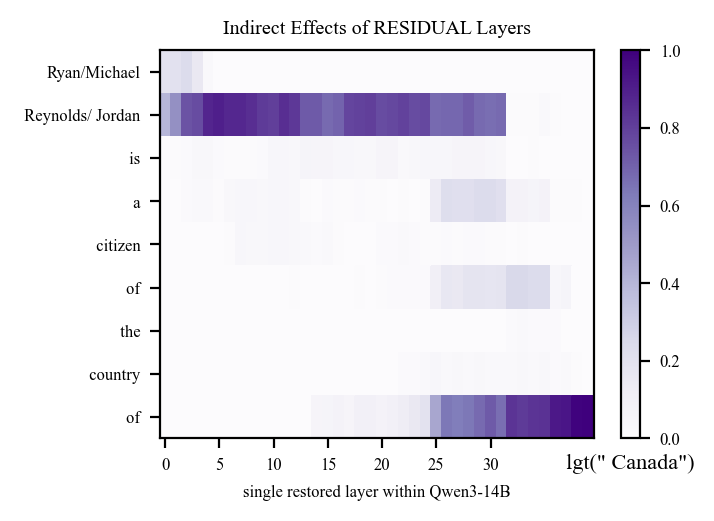

===> trace_start_idx=None
2025-05-05 12:50:50 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.427734375, logit=14.875, token_id=6864, metadata=None)
2025-05-05 12:50:50 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.46875, logit=14.25, token_id=279, metadata=None)
2025-05-05 12:50:50 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00148773193359375, logit=8.5, token_id=6864, metadata=None)
2025-05-05 12:50:50 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 360/360 [00:14<00:00, 25.04it/s]

2025-05-05 12:51:05 src.trace INFO     base_score=14.875 | low_score=8.5
2025-05-05 12:51:05 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9c7d35d150>
2025-05-05 12:51:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-05 12:51:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-05 12:51:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


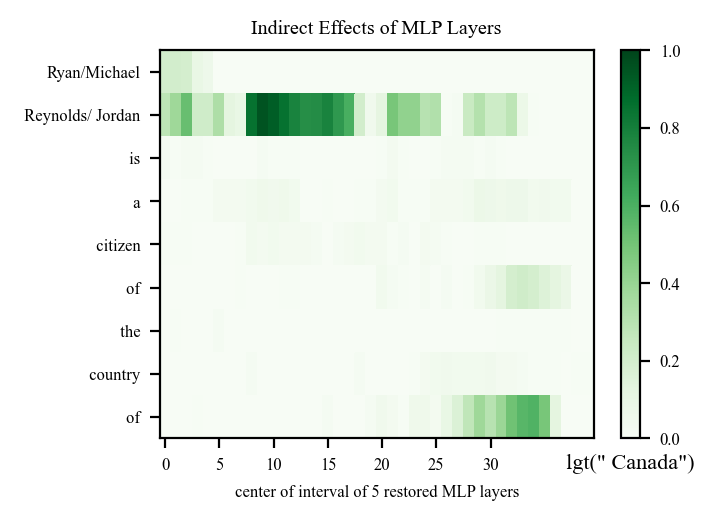

===> trace_start_idx=None
2025-05-05 12:51:05 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.427734375, logit=14.875, token_id=6864, metadata=None)
2025-05-05 12:51:05 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.46875, logit=14.25, token_id=279, metadata=None)
2025-05-05 12:51:05 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00148773193359375, logit=8.5, token_id=6864, metadata=None)
2025-05-05 12:51:05 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 360/360 [00:14<00:00, 24.72it/s]

2025-05-05 12:51:20 src.trace INFO     base_score=14.875 | low_score=8.5
2025-05-05 12:51:20 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9c7d57a990>
2025-05-05 12:51:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-05 12:51:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-05-05 12:51:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


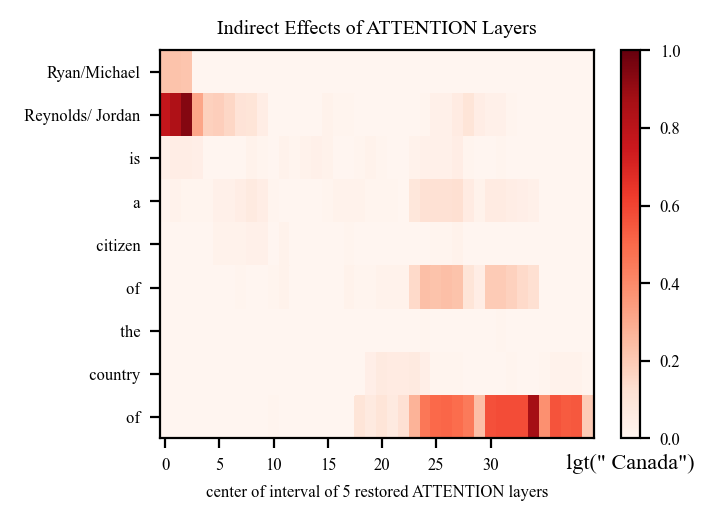

In [101]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt_check,
        prompt_template=prompt_template,
        clean_subj=clean_subj,
        patched_subj=patch_subj,
        trace_start_marker=None,
        metric="logit",
        # metric="prob",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=None,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

## Bi-Association

In [112]:
from src.probing.utils import prepare_probing_input, get_lm_generated_answer

Instructions = """Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ["Thea Bridgeport", "Isabella Garcia"]
# entities = ["Issac Newton", "Ipad"]
entities = ["Michael Jackson", "Prince"]

prefix = f"""{Instructions}
{examples}
"""

#######################################################################
# enable_reasoning = "deepseek" in model_key.lower()
enable_reasoning = True
# enable_reasoning = False
#######################################################################

connection_mt = mt_check
# connection_mt = mt

connection_prompt = prepare_probing_input(
    mt=connection_mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model=enable_reasoning,
    # answer_prefix=" They are/were both"
)

print(connection_mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=connection_mt, prompt=connection_prompt, 
    is_a_reasoning_model=enable_reasoning,
)
print(f"{answer=}")

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Michael Jackson and Prince
A:
Try to keep your thinking is less than 5 sentences.